In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error 
from sklearn.metrics import mean_absolute_error


In [112]:
df = pd.read_csv('../data/consolidated_data/training_dataset.csv',index_col='date')
df.drop(columns=['Unnamed: 0','state'], inplace=True)
df = df.groupby('date').sum()
df.index = pd.to_datetime(df.index)
df = df.asfreq('d')
date_index = df.index


In [4]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['cases_new'])
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}' )
print(f'Critical Values: {result[4]}')

ADF Statistic: -4.176908825015194
p-value: 0.0007207787314412768
Critical Values: {'1%': -3.4346453058155175, '5%': -2.8634371105641443, '10%': -2.5677799947325988}


In [5]:
#scaler = MinMaxScaler()
#columns = df.columns
#scaled_Df= scaler.fit_transform(df.to_numpy())
#df = pd.DataFrame(scaled_Df,columns=columns,index=date_index)

In [3]:
split_index = int(0.5 * len(df))
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

print("Training data shape:", train_data.shape)

print("Testing data shape:", test_data.shape, test_data)

Training data shape: (774, 26)
Testing data shape: (774, 26)             cases_new  cases_recovered  cases_active  cases_unvax  cases_pvax  \
date                                                                            
2022-03-09      30246            26653        310167         4258         630   
2022-03-10      30787            26457        314427         4429         668   
2022-03-11      32800            24444        322707         4756         769   
2022-03-12      26250            25089        323791         3545         692   
2022-03-13      22535            25356        320883         3207         502   
...               ...              ...           ...          ...         ...   
2024-04-16        110               44          7736           21           1   
2024-04-17        125               40          7821           20           0   
2024-04-18        134               31          7924           12           0   
2024-04-19        135               21          

In [167]:
def evaluate(test_data,pred):
    print(f'MSE : {mean_squared_error(test_data.cases_new,pred)}')
    print(f'RMSE : {root_mean_squared_error(test_data.cases_new,pred)}')
    print(f'R2 : {r2_score(test_data.cases_new,pred)}')
    print(f'MAE : {mean_absolute_error(test_data.cases_new,pred)}')

---

In [146]:
from statsmodels.tsa.seasonal import seasonal_decompose

result=seasonal_decompose(df['cases_new'], period=365)
trend = result.trend
seasonal = result.seasonal
residual = result.resid

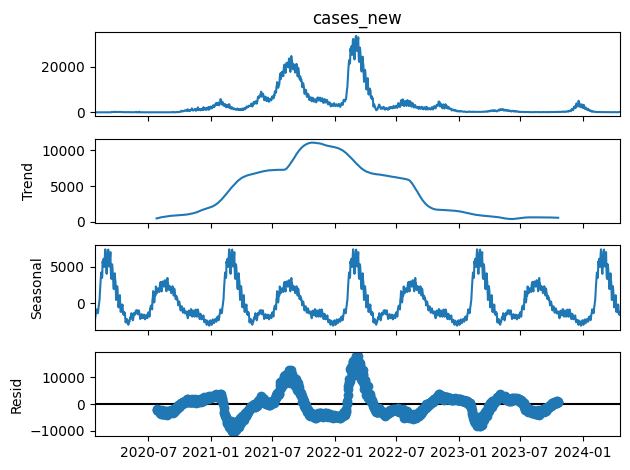

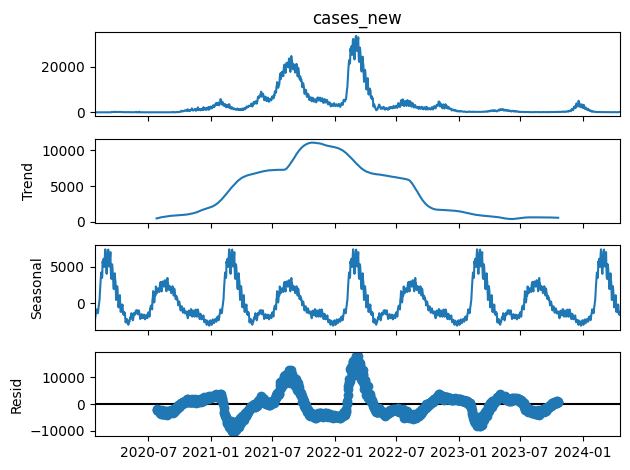

In [147]:
result.plot()

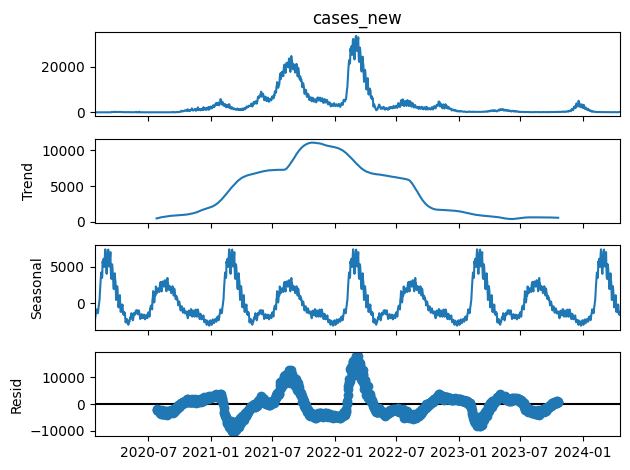

In [148]:
data_diff = df.diff()
data_diff = df.dropna()

dec = seasonal_decompose(data_diff['cases_new'],period = 365).plot()
plt.show()

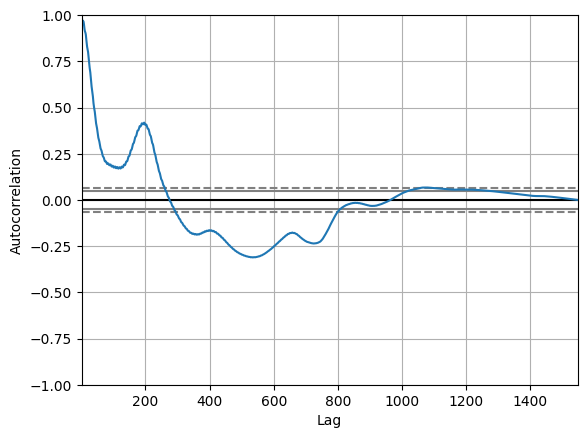

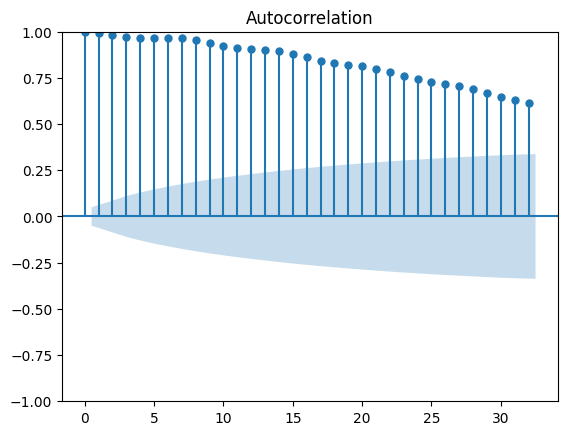

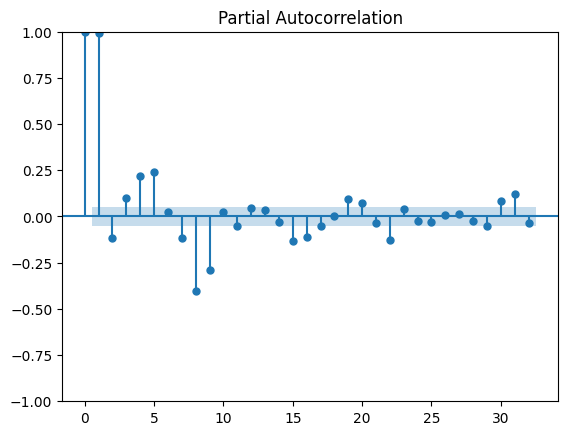

In [149]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['cases_new'])
plot_acf(df['cases_new'])
plot_pacf(df['cases_new'])
plt.show()

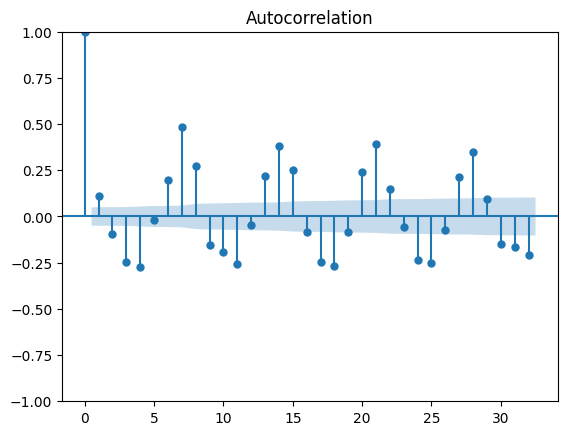

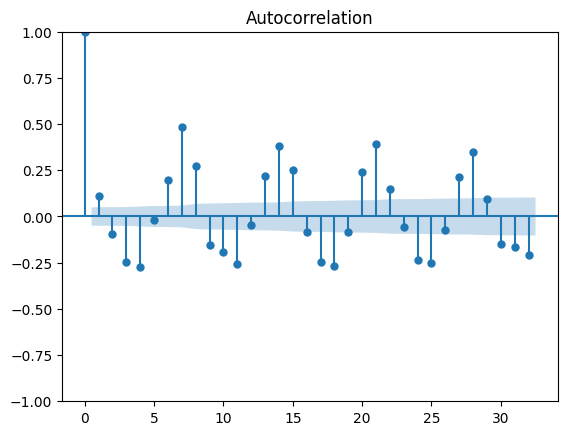

In [150]:
plot_acf(df['cases_new'].diff().dropna())

### ARIMA

In [151]:
import pmdarima as pm

model = pm.auto_arima(train_data['cases_new'], 
                      m=7,                                   
                      seasonal=True,  
                      stationary=True,
                      d=None,            
                      test='adf',
                      start_p=0, start_q=0,             
                      trace=True,  
                      )


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=13686.896, Time=0.86 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=15870.201, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.58 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=14322.917, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=16173.428, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=15003.064, Time=0.42 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   : AIC=inf, Time=3.33 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=14129.783, Time=1.47 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=14466.802, Time=0.87 sec
 ARIMA(0,0,0)(2,0,0)[7] intercept   : AIC=inf, Time=2.13 sec
 ARIMA(0,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=2.57 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=12364.270, Time=1.09 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=12490.538, Time=0.73 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=12386.1

e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\pmdarima\arima\_auto_solvers.py:524: ModelFitWarning: Error fitting  ARIMA(1,0,1)(2,0,0)[7]           (if you do not want to see these warnings, run with error_action="ignore").
Traceback:
Traceback (most recent call last):
  File "e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\pmdarima\arima\_auto_solvers.py", line 508, in _fit_candidate_model
    fit.fit(y, X=X, **fit_params)
  File "e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\pmdarima\arima\arima.py", line 603, in fit
    self._fit(y, X, **fit_args)
  File "e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\pmdarima\arima\arima.py", line 524, in _fit
    fit, self.arima_res_ = _fit_wrapper()
  File "e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\pmdarima\arima\arima.py", line 510, in _fit_wrapper
    fitted = arima.fit(
  File "e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py", li

 ARIMA(1,0,1)(2,0,0)[7]             : AIC=inf, Time=nan sec
 ARIMA(1,0,1)(2,0,2)[7]             : AIC=inf, Time=1.86 sec
 ARIMA(0,0,1)(1,0,1)[7]             : AIC=13286.319, Time=0.76 sec
 ARIMA(1,0,0)(1,0,1)[7]             : AIC=12362.297, Time=0.67 sec
 ARIMA(2,0,1)(1,0,1)[7]             : AIC=12371.698, Time=0.81 sec
 ARIMA(1,0,2)(1,0,1)[7]             : AIC=12360.592, Time=0.81 sec
 ARIMA(0,0,0)(1,0,1)[7]             : AIC=13686.836, Time=0.28 sec
 ARIMA(0,0,2)(1,0,1)[7]             : AIC=inf, Time=1.40 sec
 ARIMA(2,0,0)(1,0,1)[7]             : AIC=12358.188, Time=0.54 sec
 ARIMA(2,0,2)(1,0,1)[7]             : AIC=12361.921, Time=1.00 sec

Best model:  ARIMA(1,0,1)(1,0,1)[7]          
Total fit time: 74.195 seconds


In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  774
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood               -6174.047
Date:                           Mon, 08 Jul 2024   AIC                          12358.093
Time:                                   16:43:09   BIC                          12381.351
Sample:                               01-25-2020   HQIC                         12367.042
                                    - 03-08-2022                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9899      0.003    360.620      0.000       0.984       0.995
ma.L1         -0.0974      0.018     -5.423      0.000      -0.133      -0.062
ar.S.L7        0.9539      0.017     55.458      0.000       0.920       0.988
ma.S.L7       -0.6523      0.028    -22.902      0.000      -0.708      -0.596
sigma2      4.882e+05   9668.192     50.497      0.000    4.69e+05    5.07e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              4669.18
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):             518.08   Skew:                             0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                        15.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [15]:
future_dates_count = 1
forecast, conf_int = model.predict(n_periods= 773 + future_dates_count, return_conf_int=True)
forecast_index = test_data.index
forecast_dates = pd.date_range(start=test_data.index[0], periods=future_dates_count)
print(forecast)

2022-03-09    33388.646836
2022-03-10    34994.208374
2022-03-11    35183.082748
2022-03-12    34818.836229
2022-03-13    31952.098599
                  ...     
2024-04-16     1026.427082
2024-04-17     1029.527482
2024-04-18     1029.945670
2024-04-19     1022.546680
2024-04-20     1012.147444
Freq: D, Length: 774, dtype: float64


In [16]:
arima_forecast = pd.DataFrame({'forecast':forecast},index=forecast_dates)

In [17]:
len(forecast)

774

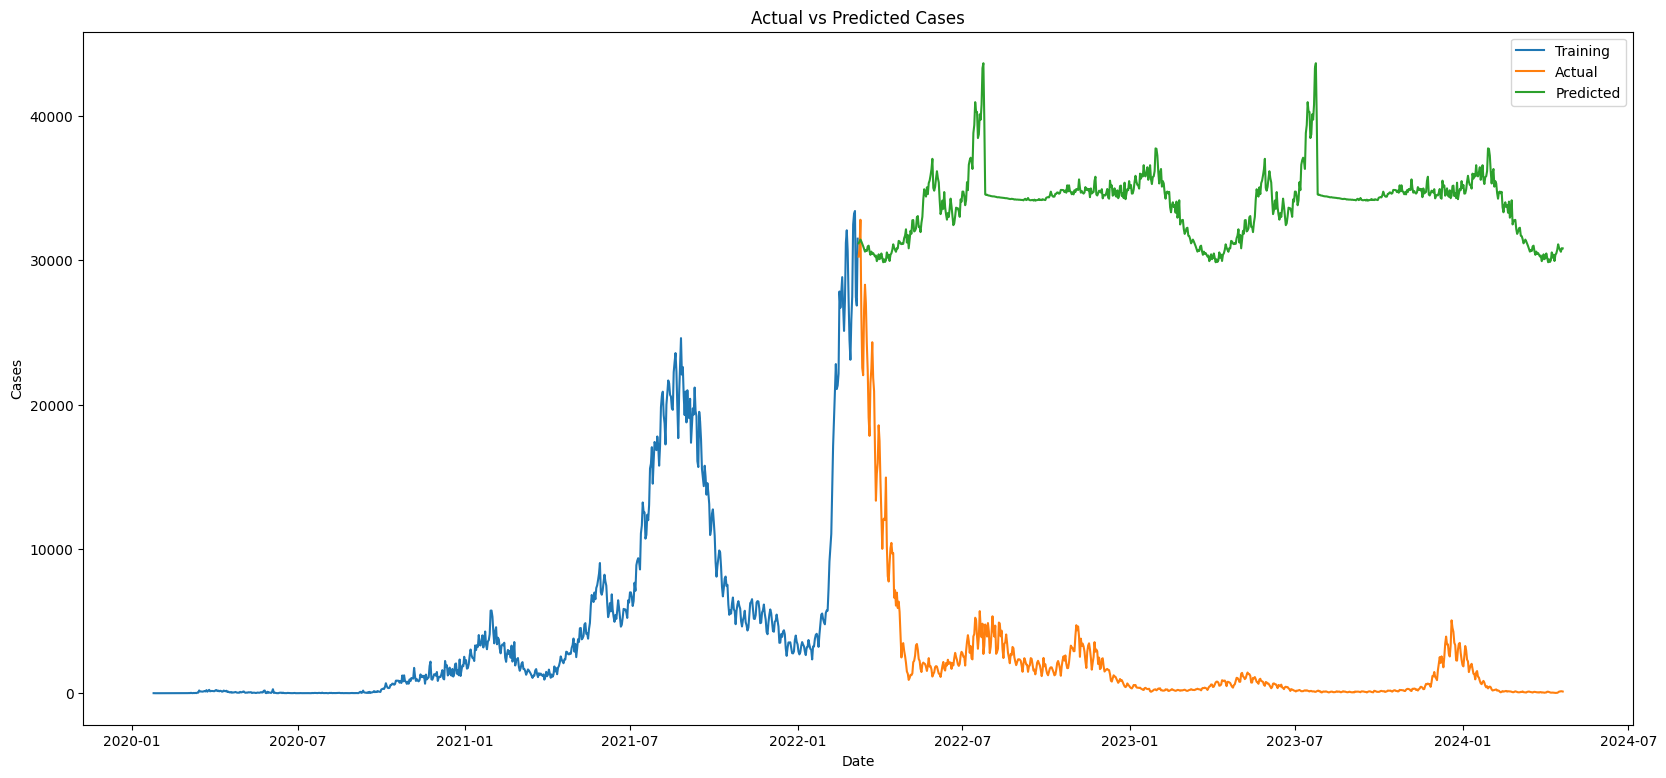

In [66]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,9))
sns.lineplot(data=train_data, x=train_data.index, y='cases_new', label='Training')
sns.lineplot(data=test_data, x=test_data.index, y='cases_new', label='Actual')
sns.lineplot(data=forecast, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('Actual vs Predicted Cases')
plt.legend()
plt.show()

In [19]:
evaluate(test_data,forecast)

MSE : 379529815.4036303
RMSE : 19481.524976336692
R2 : -20.547017154684962
MAE : 14616.731446633346


In [20]:
"""import pickle
with open("ARIMA_model.pkl", "wb") as file:
    pickle.dump(model, file)"""

'import pickle\nwith open("ARIMA_model.pkl", "wb") as file:\n    pickle.dump(model, file)'

----

In [152]:
from prophet import Prophet

In [158]:
# Modifying df to fit prophet model
split_index = int(0.5 * len(df))
train_data = df.iloc[:split_index]
test_data = df.iloc[split_index:]

print("Training data shape:", train_data.shape)

print("Testing data shape:", test_data.shape, test_data)

#Training Data
trainprop_df = train_data
trainprop_df['ds'] = train_data.index
trainprop_df.rename(columns={'cases_new':'y'},inplace=True)


#Testing Data
testprop_df = test_data
testprop_df['ds'] = test_data.index
testprop_df = testprop_df.reset_index(drop=True)

'''future_dates_count = 365//4
forecast_dates = pd.date_range(start=test_data.index[-1], periods=future_dates_count)
testprop_df =pd.DataFrame({'ds':forecast_dates})'''

print([trainprop_df.head(),testprop_df.head()])

Training data shape: (774, 26)
Testing data shape: (774, 26)             cases_new  cases_recovered  cases_active  cases_unvax  cases_pvax  \
date                                                                            
2022-03-09      30246            26653        310167         4258         630   
2022-03-10      30787            26457        314427         4429         668   
2022-03-11      32800            24444        322707         4756         769   
2022-03-12      26250            25089        323791         3545         692   
2022-03-13      22535            25356        320883         3207         502   
...               ...              ...           ...          ...         ...   
2024-04-16        110               44          7736           21           1   
2024-04-17        125               40          7821           20           0   
2024-04-18        134               31          7924           12           0   
2024-04-19        135               21          

C:\Users\Marcus Ong\AppData\Local\Temp\ipykernel_19696\2043758352.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainprop_df['ds'] = train_data.index
C:\Users\Marcus Ong\AppData\Local\Temp\ipykernel_19696\2043758352.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainprop_df.rename(columns={'cases_new':'y'},inplace=True)
C:\Users\Marcus Ong\AppData\Local\Temp\ipykernel_19696\2043758352.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

In [159]:
trainprop_df

,y,cases_recovered,cases_active,cases_unvax,cases_pvax,cases_fvax,cases_0_4,cases_5_11,cases_12_17,cases_18_29,...,daily,admitted_covid_hospital,admitted_total_hospital,discharged_covid_hospital,discharged_total_hospital,hosp_covid_hospital,icu_covid,vent_covid,cases_new_capita,ds
date,,,,,,,,,,,,,,,,,,,,,
2020-01-25,4,0,4,4,0,0,0,0,0,0,...,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,1.054241e-06,2020-01-25
2020-01-26,0,0,4,0,0,0,0,0,0,0,...,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,0.000000e+00,2020-01-26
2020-01-27,0,0,4,0,0,0,0,0,0,0,...,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,0.000000e+00,2020-01-27
2020-01-28,0,0,4,0,0,0,0,0,0,0,...,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,0.000000e+00,2020-01-28
2020-01-29,3,0,7,3,0,0,1,0,0,0,...,0.0,96.0,176.0,80.0,144.0,448.0,32.0,16.0,9.829920e-07,2020-01-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-04,33209,26352,305017,5164,617,10958,1880,2285,1517,8977,...,84379.0,1994.0,2626.0,1517.0,1932.0,7130.0,348.0,211.0,1.889241e-02,2022-03-04
2022-03-05,33406,27143,311213,4899,617,10847,1800,2211,1508,9184,...,70817.0,2020.0,2574.0,1523.0,1959.0,7391.0,372.0,226.0,1.815530e-02,2022-03-05
2022-03-06,27435,30335,308258,4055,516,8670,1573,1757,1110,7310,...,58853.0,1742.0,2213.0,1346.0,1727.0,7416.0,380.0,216.0,1.579195e-02,2022-03-06


In [160]:
m = Prophet(growth='logistic')
trainprop_df['cap'] = df['cases_new'].max() 
trainprop_df['floor'] = 0
m.fit(trainprop_df)

C:\Users\Marcus Ong\AppData\Local\Temp\ipykernel_19696\917745868.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainprop_df['cap'] = df['cases_new'].max()
C:\Users\Marcus Ong\AppData\Local\Temp\ipykernel_19696\917745868.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trainprop_df['floor'] = 0
17:36:34 - cmdstanpy - INFO - Chain [1] start processing
17:36:34 - cmdstanpy - INFO - Chain [1] done processing


In [161]:
testprop_df['cap'] = df['cases_new'].max()
testprop_df['floor'] = 0
forecastProphet = m.predict(testprop_df)

In [162]:
forecastProphet

,ds,trend,cap,floor,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2022-03-09,16733.331945,33406,0,13439.457891,23418.463133,16733.331945,16733.331945,1651.619018,1651.619018,...,74.583376,74.583376,74.583376,1577.035642,1577.035642,1577.035642,0.0,0.0,0.0,18384.950963
1,2022-03-10,16782.503449,33406,0,13627.869630,23895.925676,16782.503446,16782.503446,1556.683931,1556.683931,...,295.766368,295.766368,295.766368,1260.917563,1260.917563,1260.917563,0.0,0.0,0.0,18339.187380
2,2022-03-11,16831.673575,33406,0,13163.614207,23240.361662,16831.673555,16831.673555,1257.709962,1257.709962,...,309.358919,309.358919,309.358919,948.351043,948.351043,948.351043,0.0,0.0,0.0,18089.383537
3,2022-03-12,16880.841471,33406,0,12256.970830,22549.272025,16880.841411,16880.841411,834.536811,834.536811,...,191.452725,191.452725,191.452725,643.084086,643.084086,643.084086,0.0,0.0,0.0,17715.378283
4,2022-03-13,16930.006285,33406,0,11661.087666,21512.493494,16930.006181,16930.006181,136.645737,136.645737,...,-211.960620,-211.960620,-211.960620,348.606356,348.606356,348.606356,0.0,0.0,0.0,17066.652022
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
769,2024-04-16,33050.181025,33406,0,27459.736195,37460.779285,33049.637447,33050.713509,-907.203281,-907.203281,...,-118.109887,-118.109887,-118.109887,-789.093394,-789.093394,-789.093394,0.0,0.0,0.0,32142.977745
770,2024-04-17,33052.247746,33406,0,27643.233192,37208.648316,33051.705784,33052.778091,-727.283720,-727.283720,...,74.583376,74.583376,74.583376,-801.867097,-801.867097,-801.867097,0.0,0.0,0.0,32324.964025
771,2024-04-18,33054.302590,33406,0,27415.008666,37291.715827,33053.762246,33054.830800,-522.473542,-522.473542,...,295.766368,295.766368,295.766368,-818.239910,-818.239910,-818.239910,0.0,0.0,0.0,32531.829048
772,2024-04-19,33056.345624,33406,0,27358.071962,37702.813034,33055.806528,33056.871702,-527.683540,-527.683540,...,309.358919,309.358919,309.358919,-837.042460,-837.042460,-837.042460,0.0,0.0,0.0,32528.662084


In [163]:
forecastProphet = forecastProphet[['ds','yhat','yhat_upper','yhat_lower']]
forecastProphet = forecastProphet.set_index('ds')
forecastProphet 

,yhat,yhat_upper,yhat_lower
ds,,,
2022-03-09,18384.950963,23418.463133,13439.457891
2022-03-10,18339.187380,23895.925676,13627.869630
2022-03-11,18089.383537,23240.361662,13163.614207
2022-03-12,17715.378283,22549.272025,12256.970830
2022-03-13,17066.652022,21512.493494,11661.087666
...,...,...,...
2024-04-16,32142.977745,37460.779285,27459.736195
2024-04-17,32324.964025,37208.648316,27643.233192
2024-04-18,32531.829048,37291.715827,27415.008666


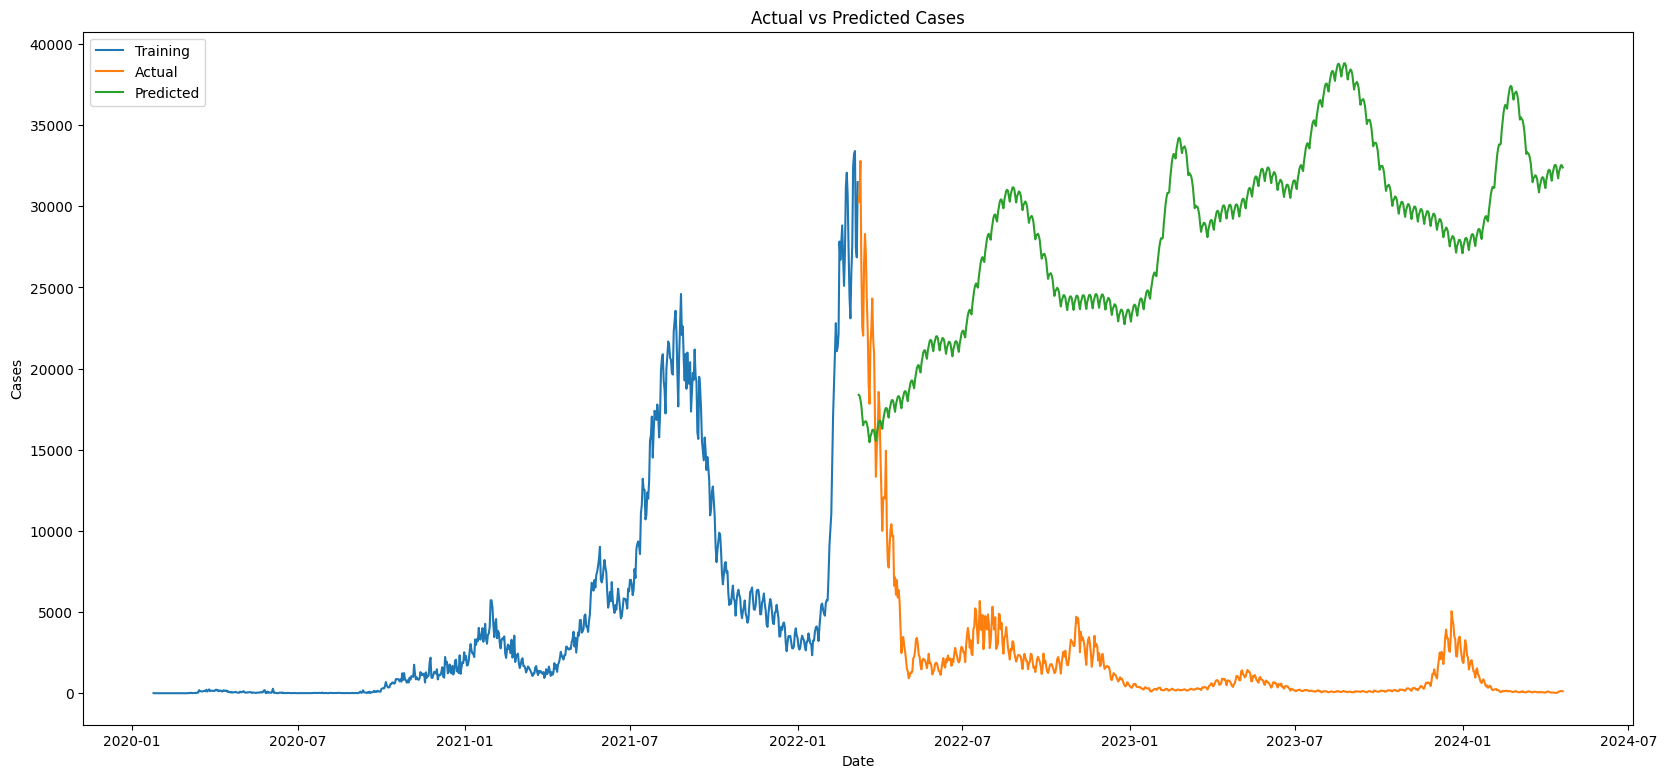

In [164]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,9))
sns.lineplot(data=train_data, x=train_data.index, y=train_data['y'], label='Training')
sns.lineplot(data=test_data, x=test_data.index, y=test_data['cases_new'], label='Actual')
sns.lineplot(data=forecastProphet['yhat'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('Actual vs Predicted Cases')
plt.legend()
plt.show()

In [165]:
evaluate(test_data,forecastProphet['yhat'])

MSE : 764633100.6512817
RMSE : 27651.999939448895
R2 : -42.41045648614285
MAE : 26664.361894891474


In [166]:

with open("prophet_model.pkl", "wb") as file:
    pickle.dump(model, file)

----

### LSTM

In [50]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(df)
df_scaled = scaler.transform(df)

In [68]:
df_scaled

array([[1.19738969e-04, 0.00000000e+00, 9.26526452e-06, ...,
        2.00878845e-02, 1.65975104e-02, 5.20818829e-05],
       [0.00000000e+00, 0.00000000e+00, 9.26526452e-06, ...,
        2.00878845e-02, 1.65975104e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 9.26526452e-06, ...,
        2.00878845e-02, 1.65975104e-02, 0.00000000e+00],
       ...,
       [4.01125546e-03, 9.15210203e-04, 2.44695636e-02, ...,
        1.88323917e-03, 3.11203320e-03, 4.77627571e-03],
       [4.04119021e-03, 6.19981105e-04, 2.48216437e-02, ...,
        1.88323917e-03, 3.11203320e-03, 2.77938294e-03],
       [3.53229959e-03, 7.97118564e-04, 2.51026900e-02, ...,
        1.88323917e-03, 3.11203320e-03, 4.03468343e-03]])

In [51]:
trainX = []
trainY = []

future = 1
past = 14

for i in range(past,len(df_scaled)-future+1):
    trainX.append(df_scaled[i-past:i , 0:df.shape[1]])
    trainY.append(df_scaled[i+future-1 : i+future, 0])

In [52]:
len(df_scaled)

1548

In [53]:
trainX, trainY =np.array(trainX),np.array(trainY)

In [32]:
trainX.shape

(1534, 14, 26)

In [33]:
trainY.shape

(1534, 1)

In [34]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout

In [54]:
model = Sequential()
model.add(LSTM(128,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(trainY.shape[1]))

model.compile(optimizer='adam',loss='mse')
model.summary()

e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 14, 128)        │        79,360 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,001 (390.63 KB)

 Trainable params: 100,001 (390.63 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
history = model.fit(trainX,trainY,epochs=10,batch_size=16,validation_split=0.1,verbose=1)

Epoch 1/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 0.0136 - val_loss: 5.2139e-04
Epoch 2/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0049 - val_loss: 3.0131e-04
Epoch 3/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0055 - val_loss: 3.1907e-04
Epoch 4/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0057 - val_loss: 2.8422e-04
Epoch 5/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0039 - val_loss: 2.8311e-04
Epoch 6/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0037 - val_loss: 3.9587e-04
Epoch 7/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0035 - val_loss: 3.9663e-04
Epoch 8/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0032 - val_loss: 3.3956e-04
Epoch 9/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - val_loss: 2.7217e-04
Epoch 10/10
87/87 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0040 - val_loss: 4.2024e-04


In [56]:
future_dates_count = len(test_data)
forecast_dates = pd.date_range(start=test_data.index[0], periods=future_dates_count)
forecast = model.predict(trainX[-future_dates_count:])

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step


In [57]:
trainX[-future_dates_count:]

array([[[9.33934024e-01, 6.02237837e-01, 8.58068501e-01, ...,
         1.91462649e-01, 1.98132780e-01, 1.00000000e+00],
        [9.60007184e-01, 6.88828531e-01, 8.84913061e-01, ...,
         2.05273070e-01, 2.08506224e-01, 9.55593220e-01],
        [9.17320242e-01, 6.69520548e-01, 9.09339387e-01, ...,
         2.08411802e-01, 2.03319502e-01, 9.38735248e-01],
        ...,
        [8.21259654e-01, 8.95577468e-01, 9.52027549e-01, ...,
         2.38543628e-01, 2.24066390e-01, 7.80157981e-01],
        [8.03927438e-01, 9.07120926e-01, 9.39837549e-01, ...,
         2.31010672e-01, 2.31327801e-01, 7.43953759e-01],
        [9.42645034e-01, 8.57197685e-01, 9.47175639e-01, ...,
         2.34149404e-01, 2.31327801e-01, 8.60893711e-01]],

       [[9.60007184e-01, 6.88828531e-01, 8.84913061e-01, ...,
         2.05273070e-01, 2.08506224e-01, 9.55593220e-01],
        [9.17320242e-01, 6.69520548e-01, 9.09339387e-01, ...,
         2.08411802e-01, 2.03319502e-01, 9.38735248e-01],
        [8.17188529e-01, 

In [69]:
forecast

array([[0.7179218 ],
       [0.7174513 ],
       [0.7201715 ],
       [0.73123497],
       [0.7155461 ],
       [0.6823799 ],
       [0.6460251 ],
       [0.6316977 ],
       [0.62998   ],
       [0.6256916 ],
       [0.61293036],
       [0.59049183],
       [0.5573603 ],
       [0.52164316],
       [0.5026679 ],
       [0.4950734 ],
       [0.499655  ],
       [0.4986483 ],
       [0.49425018],
       [0.4725053 ],
       [0.43511227],
       [0.40611303],
       [0.38596356],
       [0.381906  ],
       [0.38085675],
       [0.36963394],
       [0.3476622 ],
       [0.31946012],
       [0.2978897 ],
       [0.28120762],
       [0.26981956],
       [0.27213526],
       [0.26355582],
       [0.24835235],
       [0.23075186],
       [0.21757337],
       [0.21130878],
       [0.21253043],
       [0.21494843],
       [0.21799552],
       [0.20819414],
       [0.19773072],
       [0.18587989],
       [0.17805058],
       [0.16822362],
       [0.15994447],
       [0.15220313],
       [0.141

In [62]:
forecast_copies = np.repeat(forecast,df.shape[1],axis=-1)
pred = scaler.inverse_transform(forecast_copies)[:,0]

In [63]:
pred

array([23982.895  , 23967.178  , 24058.049  , 24427.635  , 23903.531  ,
       22795.582  , 21581.115  , 21102.494  , 21045.113  , 20901.854  ,
       20475.55   , 19725.97   , 18619.178  , 17426.012  , 16792.123  ,
       16538.422  , 16691.475  , 16657.844  , 16510.922  , 15784.512  ,
       14535.36   , 13566.612  , 12893.499  , 12757.952  , 12722.9    ,
       12347.991  , 11614.004  , 10671.885  ,  9951.304  ,  9394.021  ,
        9013.592  ,  9090.95   ,  8804.346  ,  8296.459  ,  7708.4966 ,
        7268.2563 ,  7058.981  ,  7099.7915 ,  7180.5674 ,  7282.3584 ,
        6954.933  ,  6605.3926 ,  6209.5034 ,  5947.9575 ,  5619.678  ,
        5343.105  ,  5084.4976 ,  4742.3096 ,  4321.1665 ,  3957.631  ,
        3653.8086 ,  3380.6162 ,  3158.1445 ,  2967.5713 ,  2800.022  ,
        2647.2395 ,  2479.3677 ,  2305.4175 ,  2161.6123 ,  2033.2625 ,
        1939.7563 ,  1896.6016 ,  1901.4957 ,  1938.4731 ,  2044.1448 ,
        2223.084  ,  2415.2385 ,  2551.6921 ,  2637.3035 ,  2663

In [64]:
forecast_dates

DatetimeIndex(['2022-03-09', '2022-03-10', '2022-03-11', '2022-03-12',
               '2022-03-13', '2022-03-14', '2022-03-15', '2022-03-16',
               '2022-03-17', '2022-03-18',
               ...
               '2024-04-11', '2024-04-12', '2024-04-13', '2024-04-14',
               '2024-04-15', '2024-04-16', '2024-04-17', '2024-04-18',
               '2024-04-19', '2024-04-20'],
              dtype='datetime64[ns]', length=774, freq='D')

In [65]:
lstm_result = pd.DataFrame({'forecast':pred},index=forecast_dates)

In [66]:
lstm_result

,forecast
2022-03-09,23982.894531
2022-03-10,23967.177734
2022-03-11,24058.048828
2022-03-12,24427.634766
2022-03-13,23903.531250
...,...
2024-04-16,677.700439
2024-04-17,679.352478
2024-04-18,681.743103
2024-04-19,685.031616


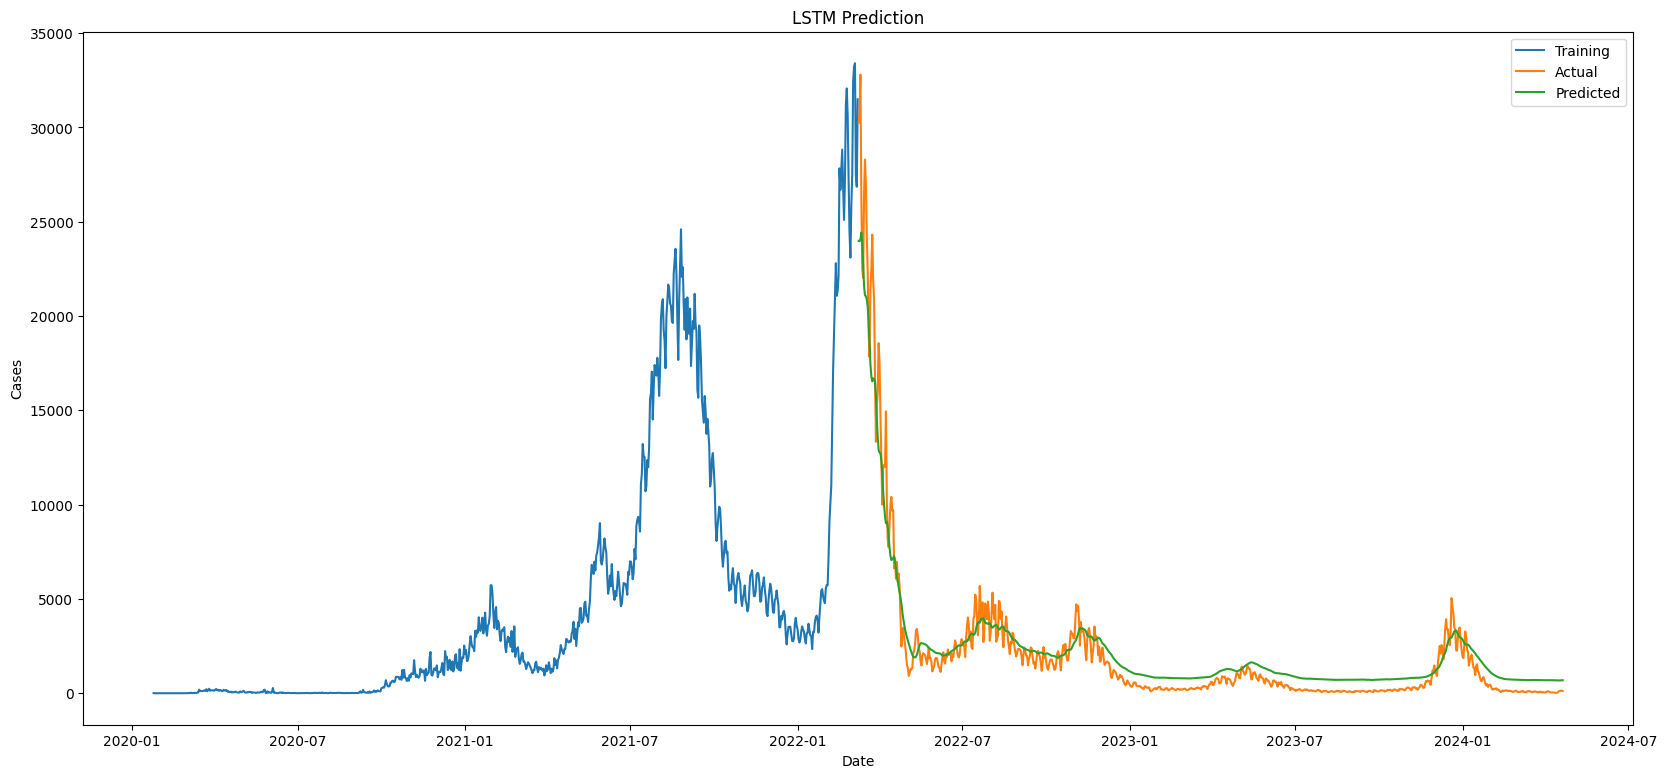

In [67]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,9))
sns.lineplot(data=train_data, x=train_data.index, y='cases_new', label='Training')
sns.lineplot(data=test_data, x=test_data.index, y='cases_new', label='Actual')
sns.lineplot(data=lstm_result,x=lstm_result.index,y='forecast', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('LSTM Prediction')
plt.legend()
plt.show()

In [109]:
evaluate(test_data,lstm_result['forecast'])

MSE : 738487.6508590244
RMSE : 859.353042037453
R2 : 0.9580739140510559
MAE : 612.0459097928779


---

In [129]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [130]:
df = pd.read_csv('../data/consolidated_data/training_dataset.csv',index_col='date')
df.drop(columns=['Unnamed: 0','state'], inplace=True)
df = df.groupby('date').sum()
df.index = pd.to_datetime(df.index)
df = df.asfreq('d')
date_index = df.index


In [131]:
df = df[['cases_new']]

In [149]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler = scaler.fit(df)
df_scaled = scaler.transform(df)

In [148]:
scaled_train = df_scaled[:split_index]
scaled_test = df_scaled[split_index:]

In [135]:
scaled_train

array([[1.19738969e-04],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [8.98042268e-05],
       [2.99347423e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [5.98694845e-05],
       [5.98694845e-05],
       [5.98694845e-05],
       [2.99347423e-05],
       [2.99347423e-05],
       [2.99347423e-05],
       [2.99347423e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.99347423e-05],
       [8.98042268e-05],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [0.00000000e+00],
       [2.99347423e-05],
       [5.98694845e-05],
       [0.00000000e+00],
       [1.19738969e-04],
       [0.00000000e+00],
       [2.09543196e-04],
       [4.19086392e-04],


In [162]:
train_gen = TimeseriesGenerator(scaled_train,scaled_train,length=14,batch_size=1)
test_gen = TimeseriesGenerator(scaled_test,scaled_test,length=14,batch_size=1)

In [141]:
model = Sequential()
model.add(LSTM(128,activation='relu',input_shape=(14,1),return_sequences=True))
model.add(LSTM(32,activation='relu',return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1))

model.compile(optimizer='adam',loss='mse')
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 14, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 87,201 (340.63 KB)

 Trainable params: 87,201 (340.63 KB)

 Non-trainable params: 0 (0.00 B)

In [142]:
history = model.fit(train_gen,validation_data=test_gen,epochs=10)

Epoch 1/10
 31/760 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0120    

e:\Github Repositories\5011-cem-ml\.venv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


760/760 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0095 - val_loss: 7.9720e-04
Epoch 2/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0098 - val_loss: 0.0014
Epoch 3/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0089 - val_loss: 9.8280e-04
Epoch 4/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0074 - val_loss: 0.0015
Epoch 5/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0072 - val_loss: 7.1435e-04
Epoch 6/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0057 - val_loss: 8.4448e-04
Epoch 7/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0058 - val_loss: 5.1535e-04
Epoch 8/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0060 - val_loss: 6.4657e-04
Epoch 9/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0056 - val_loss: 6.3670e-04
Epoch 10/10
760/760 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0064 - val_loss: 0.0011


In [143]:
future_dates_count = len(test_data)
forecast_dates = pd.date_range(start=test_data.index[0], periods=future_dates_count)

In [154]:
pred_train = model.predict(train_gen)
pred_test = model.predict(test_gen)

pred = scaler.inverse_transform(pred_train)
result = scaler.inverse_transform(pred_test)

760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
760/760 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [164]:
lstm_result = pd.DataFrame({'forecast':result.reshape(760)},index=forecast_dates[lookback_seq:])

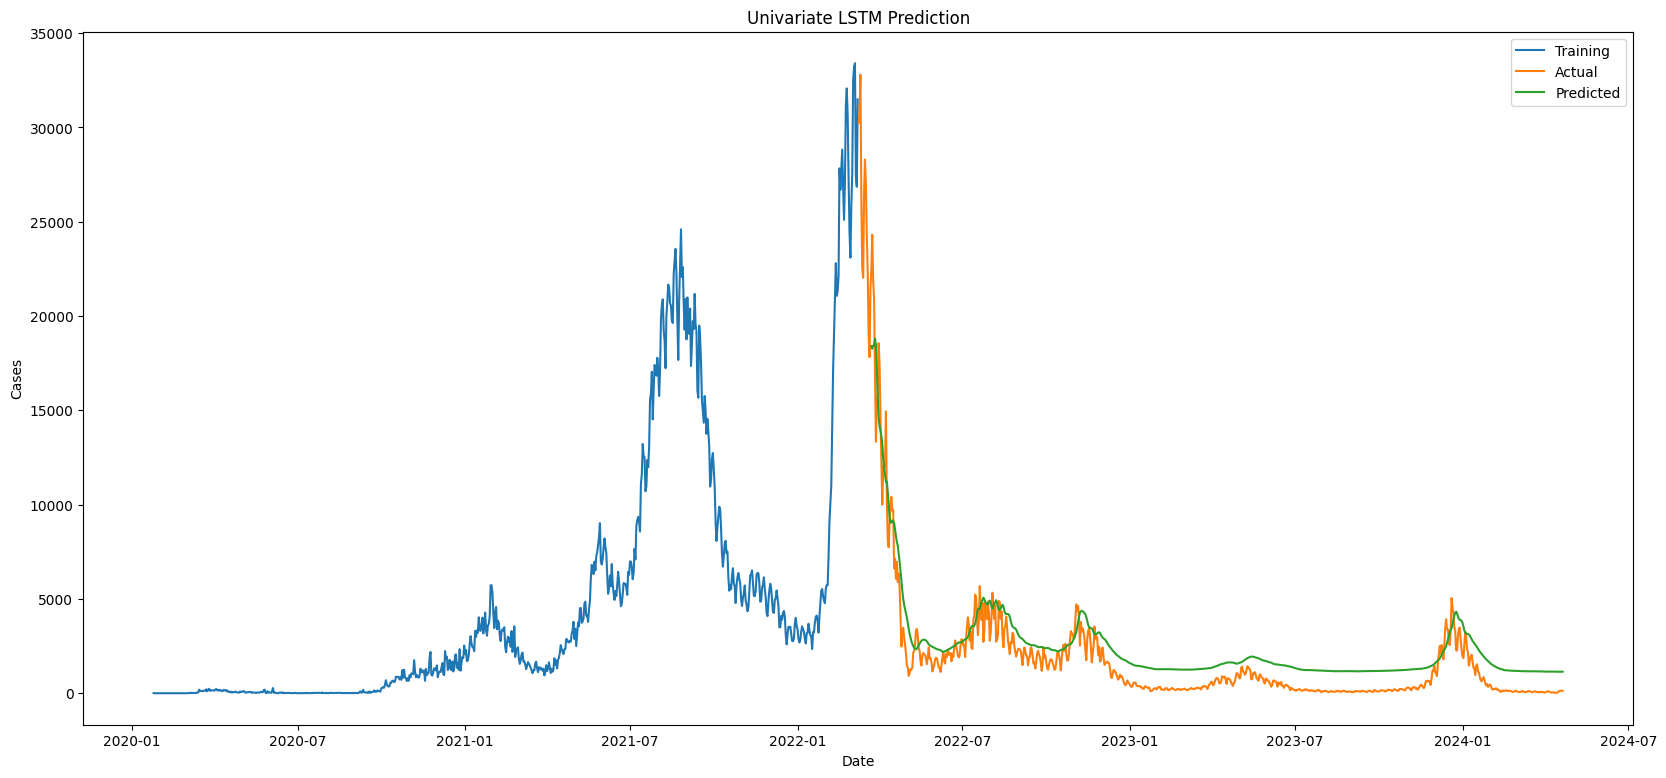

In [176]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,9))
sns.lineplot(data=train_data, x=train_data.index, y='cases_new', label='Training')
sns.lineplot(data=test_data, x=test_data.index, y='cases_new', label='Actual')
sns.lineplot(data=lstm_result,x=lstm_result.index,y='forecast', label='Predicted')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('Univariate LSTM Prediction')
plt.legend()
plt.show()

In [173]:
evaluate(test_data[14:],result)

MSE : 1279869.8571355417
RMSE : 1131.3133328727024
R2 : 0.8323770761489868
MAE : 997.8550354003906


---

### Exponential Smoothing

In [177]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [178]:
model = ExponentialSmoothing(train_data['cases_new'],seasonal='add',seasonal_periods=365)
fit = model.fit()
forecast = fit.forecast(len(test_data))

In [113]:
forecast

2022-03-09    31166.787077
2022-03-10    31278.871098
2022-03-11    31424.925459
2022-03-12    31296.335434
2022-03-13    31138.605297
                  ...     
2024-04-16    30862.214238
2024-04-17    30711.454764
2024-04-18    30582.060253
2024-04-19    30829.421628
2024-04-20    30817.298730
Freq: D, Length: 774, dtype: float64

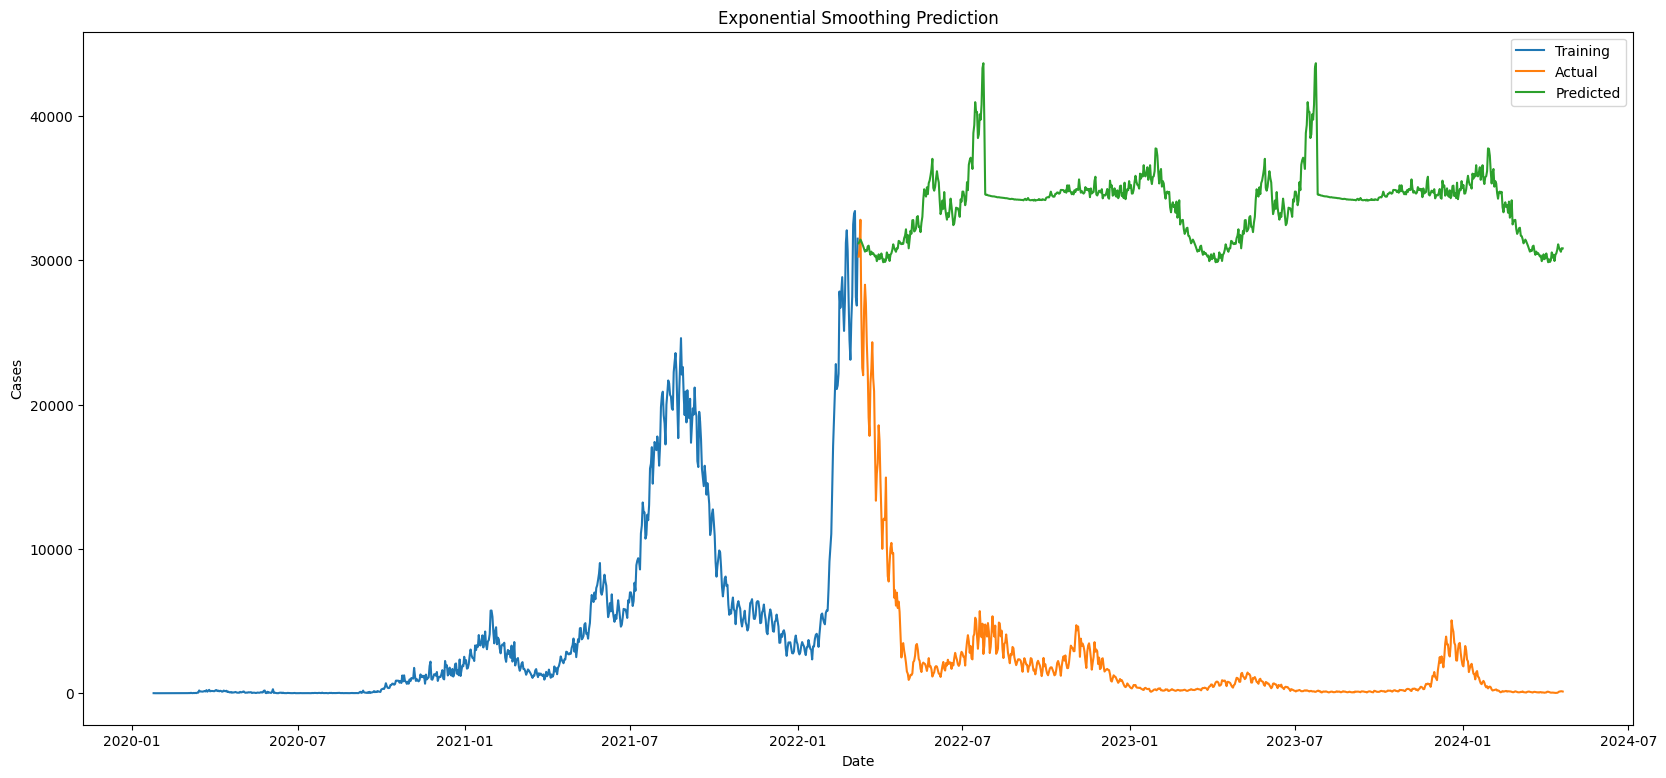

In [116]:
vis_df = df.copy()
vis_df.index = pd.to_datetime(vis_df.index)
plt.figure(figsize=(20,9))
sns.lineplot(data=train_data, x=train_data.index, y='cases_new', label='Training')
sns.lineplot(data=test_data, x=test_data.index, y='cases_new', label='Actual')
sns.lineplot(data=forecast, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.title('Exponential Smoothing Prediction')
plt.legend()
plt.show()

In [117]:
evaluate(test_data,forecast)

MSE : 1039858131.2600107
RMSE : 32246.831336737734
R2 : -58.03578607880771
MAE : 31829.37459989971
